In [10]:
#Import packages
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import execute
import qiskit.quantum_info as qi
# from qiskit.quantum_info import Pauli, SparsePauliOp
# from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms.time_evolvers.trotterization import TrotterQRTE
from qiskit.primitives import Estimator
from qiskit import Aer



import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import math
from tqdm import tqdm
from tqdm.auto import trange

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


### 1) Dynamic evolution a single spin-1/2 particle

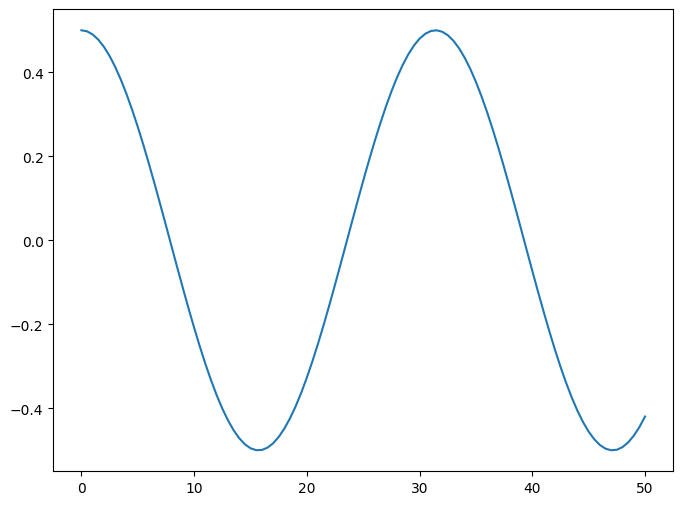

In [3]:
#Create the initial state |0>
qreg = QuantumRegister(size = 1)
qcir = QuantumCircuit(qreg)

#Define the hamiltonian
omega = 0.1
hamiltonian = qi.SparsePauliOp(data = "X", coeffs = -omega)

#Define the observable and the estimator
obs = qi.SparsePauliOp(data = "Z", coeffs = 0.5)
estimator = Estimator()

#Define the evolution problem
time = 50
initial_state = qcir
problem = TimeEvolutionProblem(hamiltonian,time,initial_state,aux_operators=[obs])

#Evolve the system
num_timesteps = 100
evolution = TrotterQRTE(estimator=estimator, num_timesteps=num_timesteps).evolve(problem)

#Get the observable values
obs_values = np.array(evolution.observables)[:,:,0][:,0]

#Visualize the time evolution of the observable
x_times = np.linspace(0,time,num=num_timesteps+1)
fig = plt.figure(figsize=(8,6))
plt.plot(x_times,obs_values,'-')


### 2) Dynamic evolution a single spin-1/2 particle with spontaneous collapse

In [71]:
#Define the collapse times
def _collapse_times(time, lam):
    """
    Generate an array of value with poisson distribution that represent the collapses.

    Parameter:
        - time(int): Max time of the experiment, the last collapse must to be before the max time
        - lam(float): Mean value of the poisson distribution that represents the rate of appearence of the collapses

    Return:
        - collapse_array(np.array): Array of sampled element from the poisson distribution 
    
    """
    t_run = 0 # count at which time we are when we sample a new value from the poisson distribution
    collapse_array = []
    while t_run <= time:
        t = np.random.poisson(lam,size=1)
        if t == 0: # beacuse the collapse doesn't happen at the same time of the previous one
            continue
        t_run += t
        if t_run <= time:
            collapse_array.append(t)
    
    return np.array(collapse_array)[:,0]

def t_coll(collapse_times):
    """
    This function calculate the exact time at which the collapses happened. This values are used in the plots

    Parameter:
        - collapse_time(np.array): Array of sampled element from the poisson distribution 

    Return:
        - t_collapses(list): Time series of the collapses
    """
    t_collapses = []
    for i in range(len(collapse_times)):
        if i == 0:
            t_collapses.append(collapse_times[0])
        else:
            t_collapses.append(t_collapses[-1] + collapse_times[i])
    return t_collapses

#Define the dynamic

def QRTE_evolution(hamiltonian, t_col, initial_state, n_timesteps, obs):
    """
    Apply the trotterization to obtain the resulting state and the mean value of the observable
    
    Parameter:
        - hamiltonian(BaseOperator | PauliSumOp): The Hamiltonian under which to evolve the system.
        - t_col(float): Total time of evolution
        - initial state(QuantumCircuit): The quantum state to be evolved
        - n_timesteps(int): he number of time-steps the full evolution time is devided into 
        - obs(ListOrDict[BaseOperator | PauliSumOp] | None): Optional list of auxiliary operators to be evaluated with the evolved initial_state and their expectation values returned.

    Return:
        - evolution(qiskit object): object that represent the result of the evolution. It must to be used then to extract the circuit after the evolution
        - obs_values(np.array): Array of mean values of the operator that is evaluated with the evolved initial_state

    """
    problem = TimeEvolutionProblem(hamiltonian, t_col, initial_state, aux_operators = [obs])
    evolution = TrotterQRTE(estimator = estimator, num_timesteps = n_timesteps).evolve(problem)
    obs_values = np.array(evolution.observables)[:,:,0][:,0]

    return evolution, obs_values

def dynamic(hamiltonian, initial_state, t_col, n_timesteps, obs):
    """
    Evaluate the dynamic until the time of collapse, then evaluate the collapse generating a random number between 0 and 1 and compare with the prob of the stato to be in |0>.

    Parameter:
        - hamiltonian(BaseOperator | PauliSumOp): The Hamiltonian under which to evolve the system.
        - initial state(QuantumCircuit): The quantum state to be evolved
        - t_col(float): Total time of evolution
        - n_timesteps(int): he number of time-steps the full evolution time is devided into 
        - obs(ListOrDict[BaseOperator | PauliSumOp] | None): Optional list of auxiliary operators to be evaluated with the evolved initial_state and their expectation values returned.

    
    Return:
        - collapse(int): where the state is collapsed
        - obs_values(np.array): Array of mean values of the operator that is evaluated with the evolved initial_state
    """

    evolution, obs_values = QRTE_evolution(hamiltonian, t_col, initial_state, n_timesteps, obs)
    state_pre = evolution.evolved_state  # extract the circuit from the ouput of the QRTE_evolution  

    #Get the state before the collapse as a vector
    backend = Aer.get_backend("statevector_simulator")
    state = execute(state_pre, backend).result().get_statevector(state_pre)

    #Collapse
    x = np.random.uniform(0,1) 
    if x <= np.abs(state[0])**2: # compare the generated number with the prob of the state to be in |0>
        return 0, obs_values
    else:
        return 1, obs_values

def experiment(hamiltonian, initial_state, time, num_timesteps, collapse_times, obs):
    """
    Apply the dynamics for the whole experiment until the end of the time of the experiment and store the values of obs_values, 
    the number of collpases in |0>, |1> and the time series of collapses.

    Parameter:
        - hamiltonian(BaseOperator | PauliSumOp): The Hamiltonian under which to evolve the system.
        - initial state(QuantumCircuit): The quantum state to be evolved
        - time(int): Total time of the experiment
        - num_timesteps(int): Number of steps in which is divide the whole experiment
        - collapse_times(np.array, dtype:int): Array of the values of the poisson samples that represent the collapses
        - obs(ListOrDict[BaseOperator | PauliSumOp] | None): Optional list of auxiliary operators to be evaluated with the evolved initial_state and their expectation values returned.

    Return:
        - all_obs_values(list_float): All the values of the mean value of the observable operator
        - counter_0(int): Count how many time collapse in |0>
        - counter_1(int): Count how many time collapse in |1>
        - collapse_values(list_float): list of mean values of the operator at the collapses
    """
    # counter for counting how many times the collapses are in |0> and |1>
    counter_0 = 0 
    counter_1 = 0

    # list to append the mean values of the observable and where there are the collapses
    all_obs_values = []
    collapse_values = []

    collapse_timesteps = collapse_times*int(num_timesteps/time)

    # do the dynamics for each interval between two collapses
    for i in trange(len(collapse_times)):
        spin_state, obs_values = dynamic(hamiltonian, initial_state, collapse_times[i], collapse_timesteps[i], obs)

        # evaluate the resulting state after the collapse
        if spin_state == 0:
            counter_0 += 1
            initial_state = QuantumCircuit(1) 
            collapse_values.append(0.5)
        else:
            counter_1 += 1
            initial_state = QuantumCircuit(1)
            initial_state.x(0)
            initial_state = initial_state
            collapse_values.append(-0.5)

        for j in range(len(obs_values)):
            all_obs_values.append(obs_values[j])

    # evalute if the last collapse coincidate with the end of the experiment. If this is false a last dynamic is calculated until the end of the time of the experiment  
    if np.sum(collapse_times) != time:
        time_fin = time - np.sum(collapse_times)
        timesteps_fin = num_timesteps - np.sum(collapse_timesteps)
        evolution_trash, obs_values = QRTE_evolution(hamiltonian, time_fin, initial_state, timesteps_fin, obs)
        for j in range(len(obs_values)):
            all_obs_values.append(obs_values[j])
    
    return all_obs_values, counter_0, counter_1, collapse_values

def visualization(all_obs_values, time, num_timesteps, collapse_values, t_collapses, collapse_times, lam, omega):
    """
    Make the plot of the obs values respect to the time of the experiment
    Parameter: 
        - all_obs_values(list_float): All the values of the mean value of the observable operator
        - time(int): Total time of the experiment
        - num_timesteps(int): Number of steps in which is divide the whole experiment
        - collapse_values(list_float): list of mean values of the operator at the collapses  
        - t_collapses(): Time series of the collapses
        - collapse_times():

    Return:
        - The plot
    """
    
    x_times = np.linspace(0,time,num=num_timesteps+len(collapse_times)+1)
    fig = plt.figure(figsize=(12,8))
    plt.plot(x_times,all_obs_values,'-', alpha = .7, color = 'blue')
    plt.plot(t_collapses, collapse_values, '.', c = 'r')
    plt.title(f'Collapse Model for 1 spin with λ = {"{:.4f}".format(1/lam)}, and ω = {"{:.4f}".format(omega)}')
    plt.xlabel('Time')
    plt.ylabel('Mean value of Sigma z')
    plt.grid()
    plt.show()

def plot_animation(X, Y, lam, omega, time, save_as_gif=False, title = 'Animation.gif'):
    n = len(X)
    
    fig = plt.figure(figsize=(12,8))

    plt.xlim([-2, time+2])
    plt.ylim([-.51,.51])
    plt.title(f'Collapse Model for 1 spin with λ = {"{:.4f}".format(1/lam)}, and ω = {"{:.4f}".format(omega)}')
    plt.xlabel("Time")
    plt.ylabel("Mean value of Sigma z")
    plt.grid(True)
    
    line, = plt.plot([], [], '-', color = 'blue', label='')  # Creating an empty plot
    
    def update(frame):
        line.set_data(X[:frame], Y[:frame])
        return line,
    
    #The interval parameter represents the delay between frames in milliseconds.
    ani = FuncAnimation(fig, update, frames=range(n), blit=True, interval=30)
    
    #plt.legend()
    
    if save_as_gif:
        ani.save(title, writer='pillow')  # Save the animation as a .gif file
    
    plt.show()

def plot_animation_2(X, Y, Z, save_as_gif=False):
    n = len(X)
    
    fig, ax = plt.subplots()
    ax.set_title("Animation of X vs Y and X vs Z")
    ax.set_xlabel("X")
    ax.set_xlim(0, 50)
    ax.set_ylim(-1.1, 1.1)
    ax.grid(True)
    
    line1, = ax.plot([], [], 'b-', label='Y')  # Plot for X vs Y
    line2, = ax.plot([], [], 'r-', label='Z')  # Plot for X vs Z
    
    def update(frame):
        line1.set_data(X[:frame], Y[:frame])
        line2.set_data(X[:frame], Z[:frame])
        return line1, line2
    
    #The interval parameter represents the delay between frames in milliseconds.
    ani = FuncAnimation(fig, update, frames=range(n), blit=True, interval=3)  # Set fps to 15
    
    ax.legend()
    
    if save_as_gif:
        ani.save("animation.gif", writer='pillow')  # Save the animation as a .gif file
    
    #plt.tight_layout()
    plt.show()

In [94]:
#Define some variables
time = 1000
num_timesteps = 2000


#Define the hamiltonian
omega = 0.01
hamiltonian = qi.SparsePauliOp(data = "X", coeffs = -omega)


#Define the observable and the estimator
obs = qi.SparsePauliOp(data = "Z", coeffs = 0.5)
estimator = Estimator()


# Define the initial state
#initial_state = QuantumCircuit(1) # intialize in |0>
# initial_state = 1/np.sqrt(2)* ( qi.Statevector.from_label("0") + qi.Statevector.from_label("1"))
initial_state = qi.Statevector.from_label("0")


# generate the poisson samples
#np.random.seed() # fix a seed
lam = 10 #lambda for the poisson distribution

collapse_times = _collapse_times(time,lam) 
t_collapse = t_coll(collapse_times) 

#print("collapse_times:", collapse_times)
#print("collapse_timesteps:", collapse_times*int(num_timesteps/time))
#print("t_collapses:", t_collapse)

In [95]:
# Do the experiment
y, counter_0, counter_1, collapse_values = experiment(hamiltonian, initial_state, time, num_timesteps, collapse_times, obs)

print("Collapse in |0>: ", counter_0)
print("Collapse in |1>: ", counter_1)


  0%|          | 0/98 [00:00<?, ?it/s]

Collapse in |0>:  62
Collapse in |1>:  36


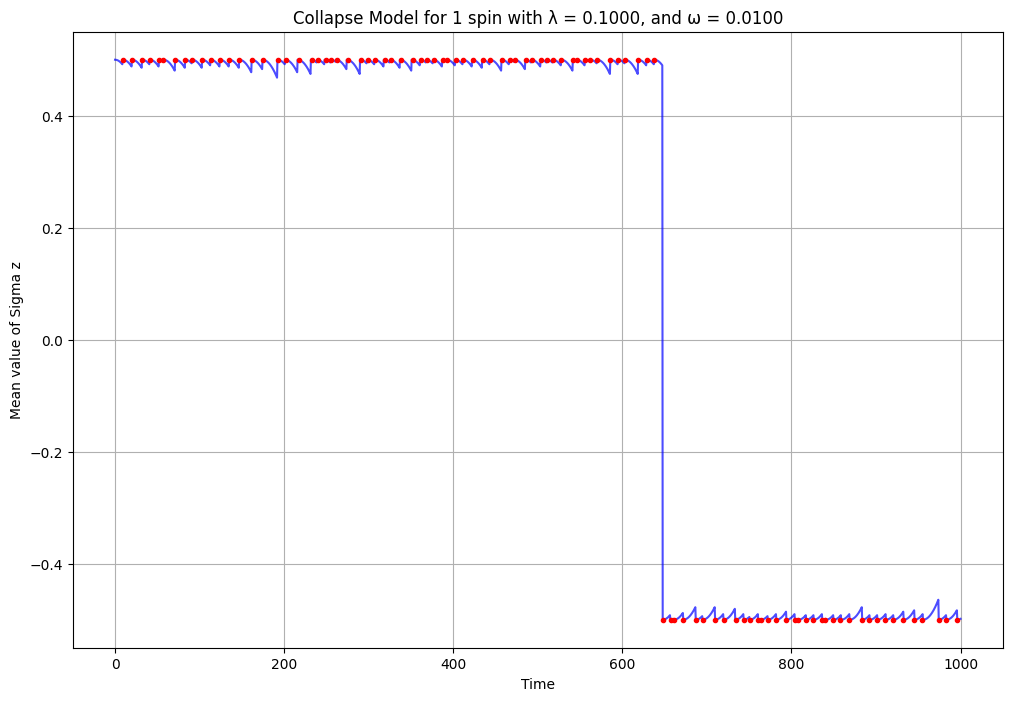

In [96]:
# visualize the plot
visualization(y, time, num_timesteps, collapse_values, t_collapse, collapse_times,lam, omega)

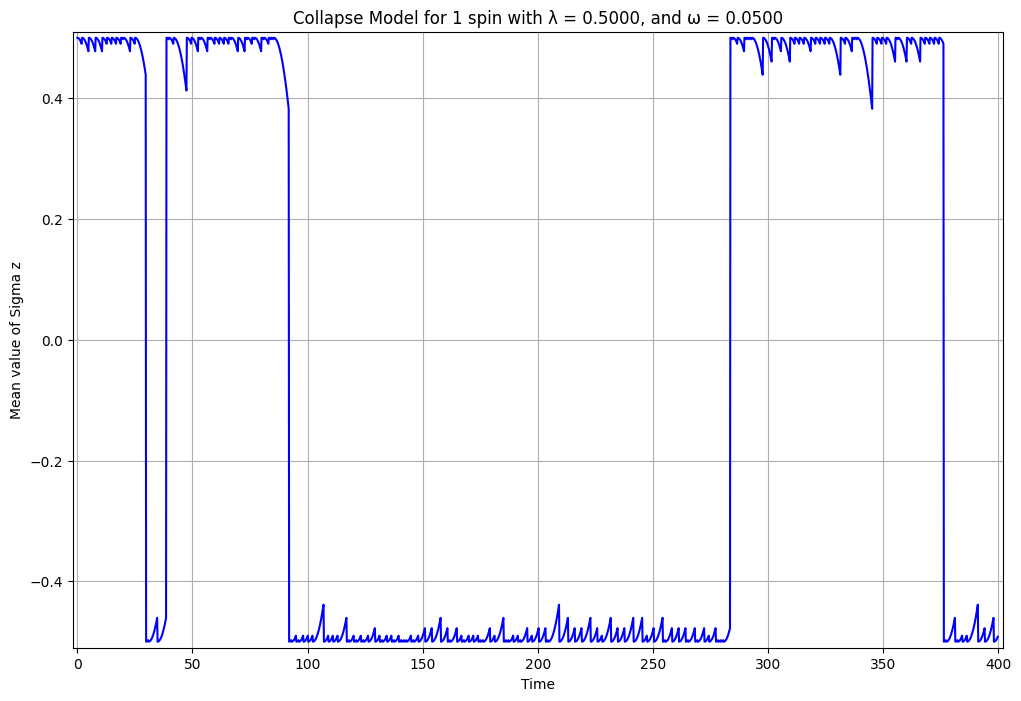

In [59]:
x_times = np.linspace(0,time,num=num_timesteps+len(collapse_times)+1)

plot_animation(x_times, np.array(y), lam, omega,time, save_as_gif=True, title='1spin_lam_0_5.gif')